# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

In [1]:
%%bash
mkdir -p $CONDA_PREFIX/etc/conda/activate.d
echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh

bash: /home/chen/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)


In [2]:
import tensorrt
print(tensorrt.__version__)
assert tensorrt.Builder(tensorrt.Logger())

8.5.1.7
[11/08/2022-12:58:13] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars


In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2022-11-08 20:09:22.281251: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1 Physical GPUs, 1 Logical GPU


2022-11-08 20:09:23.154057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 20:09:23.158653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 20:09:23.158751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 20:09:23.159141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset

### Loading

In [3]:
from scripts.data.load import load_dataset

dataset_name = "mnist"
dataset = load_dataset(dataset_name, normalize=True, batch=True, prefetch=False, cast_to_int8=False, colab=False)

Found 70000 files belonging to 1 classes.


### Training image preview

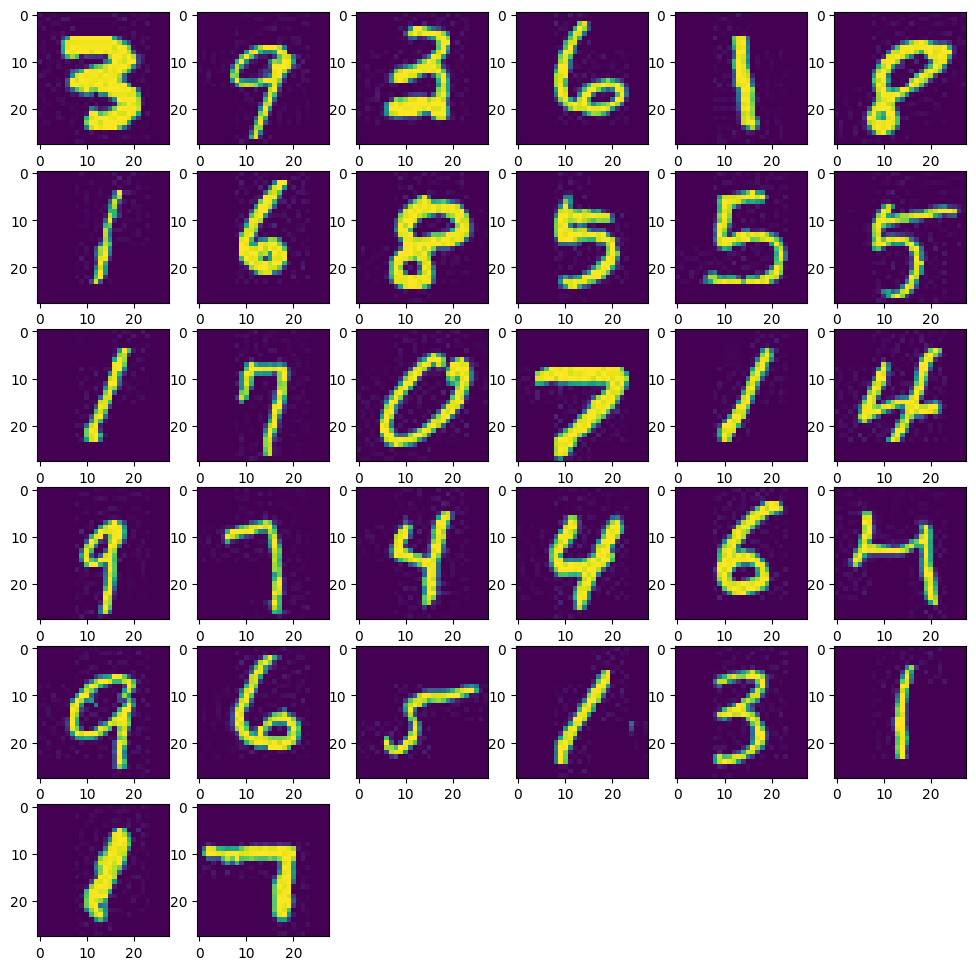

In [2]:
from scripts.data.visualization import display_images
import tensorflow as tf
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Take doesn't alter the dataset itself, so this won't affect the training
for batch in dataset.take(1):
    display_images(batch.numpy(), max_images=32)

logger.setLevel(old_level)


## Load Config

In [4]:
from config import get_config

config = get_config(dataset_name)

## Build GAN

In [ ]:
from scripts.model.build import build_model
model_name = "dcgan"
generator, discriminator = build_model(model_name, dataset_name)

## Model summaries

In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             627200    
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      5

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       3328      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 256)         0         
                                                                 
 flatten (Flatten)           (None, 12544)            

## Test Generator output

0.0055310447 0.027034793 -0.01630522


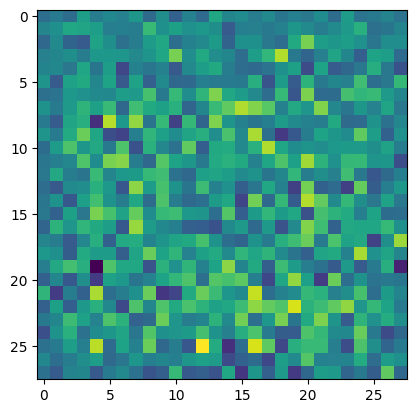

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

input_noise = tf.random.normal([1, config['dataset']['dcgan']['generator']['len_seed']])
generated_image = generator(input_noise, training=False)[0]
print(np.average(generated_image), np.max(generated_image), np.min(generated_image))
# generated_image[0]
plt.imshow((generated_image + 1)/2)

## Test Discriminator output

In [8]:
decision = discriminator(np.reshape(
                                        generated_image,                    
                                        (1, 
                                        config['dataset']['height'], 
                                        config['dataset']['width'], 
                                        config['dataset']['num_color_channels'])
                                    ),
                                    training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999988]], dtype=float32)>

## Get optimizers

In [9]:
generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

## Training functions

In [14]:
import  time, gc
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from scripts.model.loss import generator_loss, discriminator_loss
from scripts.data.visualization import display_images
import logging

def generate_and_save_images(model, epoch, test_seeds):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_seeds, training=False)
    predictions = predictions.numpy()
    fig = plt.figure(figsize=(4, 4))
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    for i, image in enumerate(predictions):
        # print(np.average(image), np.max(image), np.min(image))
        plt.subplot(4, 4, i+1)
        plt.imshow(image)
        plt.axis('off')  

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    logger.setLevel(old_level)

@tf.function()
def train_step(real_image_batch):
    input_noise_seeds = tf.random.normal([config['dataset']['batch_size'], config['dataset']['dcgan']['generator']['len_seed']])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image_batch = generator(input_noise_seeds, training=True)

        y_pred_real = discriminator(real_image_batch, training=True)
        y_pred_fake = discriminator(generated_image_batch, training=True)

        gen_loss = generator_loss(y_pred_fake)
        disc_loss = discriminator_loss(y_pred_real, y_pred_fake)

    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, num_test_seeds=16):
    gc.collect()
    if num_test_seeds < 1:
        print('Number of test seeds invalid (must be > 0)')
        return
  
    test_seeds = tf.random.normal([num_test_seeds, config['dataset']['dcgan']['generator']['len_seed']])

    for epoch in range(epochs):
        start = time.time()
        gen_loss, disc_loss = None, None

        for i, batch in enumerate(dataset):
            display.clear_output(wait=True)
            print(f'Loss for previous batch #{i}: Generator loss = {gen_loss}, Discriminator loss = {disc_loss}')
            print(f'Epoch # {epoch + 1}/{epochs}')
            print(f'Batch # {i + 1}')
            gc.collect()
            gen_loss, disc_loss = train_step(batch)
            # print(f'\nLoss for epoch #{epoch + 1}: Generator loss = {gen_loss}, Discriminator loss = {disc_loss}\n', end='\r')
        
        generate_and_save_images(generator, epoch + 1, test_seeds)


        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')
  
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, test_seeds)

## Training the model

In [15]:
import time

generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

generator_optimizer = Adam(0.0002, 0.5)
discriminator_optimizer = Adam(0.0002, 0.5)

start = time.time()
train(dataset, epochs=10)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

Loss for previous batch #113: Generator loss = 0.7357051968574524, Discriminator loss = 1.3353888988494873
Epoch # 10/10
Batch # 114


In [67]:
generator.save('/content/generator_10_epochs')

In [5]:
import tensorflow as tf

generator = tf.keras.models.load_model('/content/generator')

## Rescaling image output from [-1, 1] to [0, 255]

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

gen = tf.keras.models.load_model('./models/generator_10_epochs')
gen.compile()

In [57]:
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            10342400  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 10, 10, 1024)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 512)      13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 512)      2

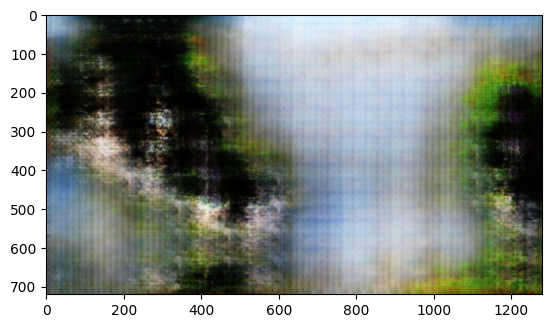

In [56]:
rand_seed = tf.random.normal([1, 100])
image = gen(rand_seed, training=False)[0]
image = image.numpy()
image = ((image - np.min(image)) * 255) / (np.max(image) - np.min(image))
# image
# image = ((image * 127.5) + 127.5)
image = image.astype(np.uint8)
plt.imshow(image)
# plt.savefig('/content/example_1_epoch.png')

In [ ]:
image = (image + 1)/(2) * 255
np.min(image), np.max(image)
# # image = np.expand_dims(image, axis=0)
# # rand_seed
plt.imshow(image[:, :, 0], cmap='gray')

## Saving the model

In [ ]:
generator.save('./models/generator')

In [ ]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator